# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = '/data'
!pip install matplotlib==2.0.2
# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

You are using pip version 9.0.1, however version 10.0.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

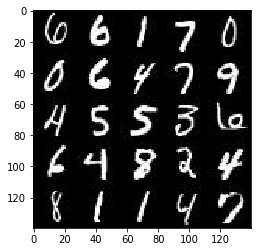

In [2]:
show_n_images = 25
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

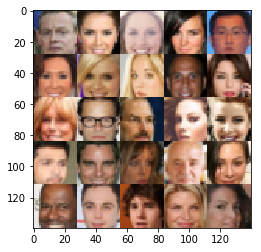

In [3]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [4]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.3.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [5]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    real_input = tf.placeholder(dtype=tf.float32,shape=(None,image_width,image_height,image_channels),name='real_input')
    z_input = tf.placeholder(dtype=tf.float32,shape=(None,z_dim),name='z_input')
    learning_rate = tf.placeholder(dtype=tf.float32,name='learning_rate')
    return real_input,z_input,learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

ERROR:tensorflow:==================================
Object was never used (type <class 'tensorflow.python.framework.ops.Operation'>):
<tf.Operation 'assert_rank_2/Assert/Assert' type=Assert>
If you want to mark it as used call its "mark_used()" method.
It was originally created here:
['File "/opt/conda/lib/python3.6/runpy.py", line 193, in _run_module_as_main\n    "__main__", mod_spec)', 'File "/opt/conda/lib/python3.6/runpy.py", line 85, in _run_code\n    exec(code, run_globals)', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py", line 16, in <module>\n    app.launch_new_instance()', 'File "/opt/conda/lib/python3.6/site-packages/traitlets/config/application.py", line 658, in launch_instance\n    app.start()', 'File "/opt/conda/lib/python3.6/site-packages/ipykernel/kernelapp.py", line 478, in start\n    self.io_loop.start()', 'File "/opt/conda/lib/python3.6/site-packages/zmq/eventloop/ioloop.py", line 177, in start\n    super(ZMQIOLoop, self).start()', 'File "/opt/co

In [6]:
def lrelu(x,alpha=0.1):
    return tf.maximum(alpha*x,x)

### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [7]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    #input size : 28*28*3
    alpha = 0.2
    with tf.variable_scope('discriminator',reuse=reuse):
        
        conv1 = tf.layers.conv2d(inputs=images,filters=128,strides=2,kernel_size=5,padding='same',activation=None,kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        bn1 = tf.layers.batch_normalization(inputs=conv1,training=True,epsilon=1e-5,momentum=0.9)
        lrelu1 = lrelu(bn1,alpha) #14*14*128
        
        conv2 = tf.layers.conv2d(inputs=lrelu1,filters=256,strides=2,kernel_size=5,padding='same',activation=None,kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02)) 
        bn2 = tf.layers.batch_normalization(inputs=conv2,training=True,epsilon=1e-5,momentum=0.9)
        lrelu2 = lrelu(bn2,alpha) #7*7*256
        
        conv3 = tf.layers.conv2d(inputs=lrelu2,filters=512,strides=2,kernel_size=5,padding='same',activation=None,kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02)) 
        bn3 = tf.layers.batch_normalization(inputs=conv3,training=True,epsilon=1e-5,momentum=0.9)
        lrelu3 = lrelu(bn3,alpha)#4*4*512
        
        flatten = tf.reshape(lrelu3,shape=(-1,4*4*512))
        logits = tf.layers.dense(inputs=flatten,units=1,activation=None,kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        outputs = tf.nn.sigmoid(logits)
        
    #output size : None,1
    return outputs,logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [8]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    reuse = not is_train
    # TODO: Implement Function
    with tf.variable_scope('generator',reuse=reuse):
        fc1 = tf.layers.dense(inputs=z,units=7*7*512)
        fc1 = tf.reshape(fc1,(-1,7,7,512))
        fc1 = tf.layers.batch_normalization(inputs=fc1,training=is_train,epsilon=1e-5,momentum=0.9)
        fc1 = lrelu(fc1)  #7*7*512
        
        tconv1 = tf.layers.conv2d_transpose(inputs=fc1,filters=256,strides=1,kernel_size=5,padding='same',activation=None,kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        bn1 = tf.layers.batch_normalization(inputs=tconv1,training=is_train,epsilon=1e-5,momentum=0.9)
        lrelu1 = lrelu(bn1) #7*7*256
        
        tconv2 = tf.layers.conv2d_transpose(inputs=fc1,filters=128,strides=2,kernel_size=5,padding='same',activation=None,kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        bn2 = tf.layers.batch_normalization(inputs=tconv2,training=is_train,epsilon=1e-5,momentum=0.9)
        lrelu1 = lrelu(bn2) #14*14*128
        
        logits = tf.layers.conv2d_transpose(inputs=lrelu1,filters=out_channel_dim,strides=2,kernel_size=5,padding='same',activation=None,kernel_initializer=tf.random_normal_initializer(mean=0.0, stddev=0.02))
        outputs = tf.nn.tanh(logits) #28*28*3
        
    return outputs


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [9]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    label_smoothness = 0.1
    
    g_model = generator(z=input_z,out_channel_dim=out_channel_dim,is_train=True)
    d_real_outputs,d_real_logits = discriminator(images=input_real,reuse=False)
    d_fake_outputs,d_fake_logits = discriminator(images=g_model,reuse=True)
    
    #d_loss_real : 
    d_loss_real = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_real_logits,labels=tf.ones_like(d_real_logits)*(1-label_smoothness)))
    
    #d_loss_fake :
    d_loss_fake = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,labels=tf.zeros_like(d_fake_logits)))
    
    #g_loss : 
    gloss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=d_fake_logits,labels=tf.ones_like(d_fake_logits)))
    
    dloss = d_loss_real + d_loss_fake
    
    return dloss, gloss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [10]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    #get weights and bias of the networks separately
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    
    '''
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    with tf.control_dependencies(update_ops):
        # Ensures that we execute the update_ops before performing the train_step
        train_step = tf.train.GradientDescentOptimizer(0.01).minimize(loss)
    '''
    #here batch normalization is the operation
    # Because the batch norm layers are not part of the graph we inforce these operation to run before the 
    # optimizers so the batch normalization layers can update their population statistics.
    
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        g_op = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(g_loss,var_list=g_vars)
        d_op = tf.train.AdamOptimizer(learning_rate=learning_rate,beta1=beta1).minimize(d_loss,var_list=d_vars)

    return d_op,g_op


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [11]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [16]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    _,image_width,image_height,image_channels = data_shape
    real_input,z_input,lr = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss,g_loss = model_loss(real_input, z_input, image_channels)
    op_d,op_g = model_opt(d_loss, g_loss, lr, beta1)
    steps=0
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps+=1
                
                batch_z = np.random.uniform(low=-1,high=1,size=(batch_size,z_dim))
                
                #training discriminator network first
                _ = sess.run(op_d,feed_dict={real_input:batch_images,
                                                     z_input:batch_z,
                                                     lr: learning_rate
                                                     })
                
                #training generator network
                _ = sess.run(op_g,feed_dict={real_input:batch_images,
                                                     z_input:batch_z,
                                                     lr: learning_rate
                                                     })
                
                #show generator output
                if steps%100==0:
                    show_generator_output(sess,50,z_input,image_channels,data_image_mode)
                
                if steps%10==0:
                    dloss_train = sess.run(d_loss,feed_dict={real_input:batch_images,z_input:batch_z})
                    gloss_train = sess.run(g_loss,feed_dict={z_input:batch_z})
                    print("Epoch:{}, Step:{}, Discriminator Loss:{}, Generator Loss:{}".format(epoch_i+1,steps,dloss_train,gloss_train))                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch:1, Step:10, Discriminator Loss:0.5568594932556152, Generator Loss:2.0783443450927734
Epoch:1, Step:20, Discriminator Loss:0.5275952816009521, Generator Loss:2.2264418601989746
Epoch:1, Step:30, Discriminator Loss:1.0112470388412476, Generator Loss:1.041846513748169
Epoch:1, Step:40, Discriminator Loss:0.7289108037948608, Generator Loss:1.6718484163284302
Epoch:1, Step:50, Discriminator Loss:0.4884146451950073, Generator Loss:2.887920379638672
Epoch:1, Step:60, Discriminator Loss:0.5152764916419983, Generator Loss:2.6731715202331543
Epoch:1, Step:70, Discriminator Loss:3.641757011413574, Generator Loss:0.08151563256978989
Epoch:1, Step:80, Discriminator Loss:0.6867281198501587, Generator Loss:2.5386667251586914
Epoch:1, Step:90, Discriminator Loss:0.5985544919967651, Generator Loss:3.2656350135803223


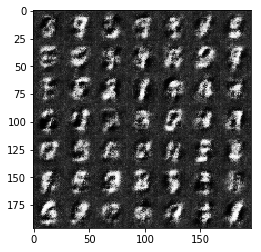

Epoch:1, Step:100, Discriminator Loss:0.6974303722381592, Generator Loss:1.9015734195709229
Epoch:1, Step:110, Discriminator Loss:0.6162157654762268, Generator Loss:2.3540358543395996
Epoch:1, Step:120, Discriminator Loss:0.5963178873062134, Generator Loss:2.0670199394226074
Epoch:1, Step:130, Discriminator Loss:0.6810048818588257, Generator Loss:1.5465235710144043
Epoch:1, Step:140, Discriminator Loss:0.6091301441192627, Generator Loss:2.7732584476470947
Epoch:1, Step:150, Discriminator Loss:0.8094419240951538, Generator Loss:1.2349128723144531
Epoch:1, Step:160, Discriminator Loss:0.584640383720398, Generator Loss:1.816802740097046
Epoch:1, Step:170, Discriminator Loss:0.5155763030052185, Generator Loss:2.536964178085327
Epoch:1, Step:180, Discriminator Loss:1.7566579580307007, Generator Loss:5.866820335388184
Epoch:1, Step:190, Discriminator Loss:0.5023889541625977, Generator Loss:2.7736260890960693


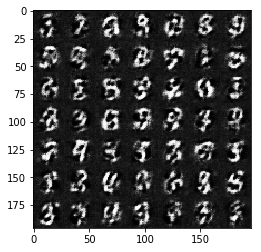

Epoch:1, Step:200, Discriminator Loss:0.605947732925415, Generator Loss:3.610541343688965
Epoch:1, Step:210, Discriminator Loss:0.46081697940826416, Generator Loss:2.651010274887085
Epoch:1, Step:220, Discriminator Loss:0.4925004243850708, Generator Loss:2.2533035278320312
Epoch:1, Step:230, Discriminator Loss:0.49867749214172363, Generator Loss:2.8509724140167236
Epoch:1, Step:240, Discriminator Loss:0.49777287244796753, Generator Loss:2.399580478668213
Epoch:1, Step:250, Discriminator Loss:0.4815818667411804, Generator Loss:3.1306817531585693
Epoch:1, Step:260, Discriminator Loss:0.48405760526657104, Generator Loss:3.046808958053589
Epoch:1, Step:270, Discriminator Loss:0.45662474632263184, Generator Loss:2.7617554664611816
Epoch:1, Step:280, Discriminator Loss:1.228548526763916, Generator Loss:5.613568305969238
Epoch:1, Step:290, Discriminator Loss:0.5811496376991272, Generator Loss:3.6531083583831787


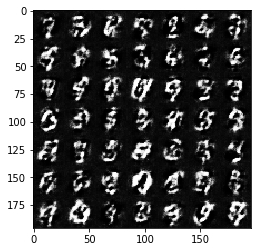

Epoch:1, Step:300, Discriminator Loss:0.46943986415863037, Generator Loss:3.3661489486694336
Epoch:1, Step:310, Discriminator Loss:0.5574263334274292, Generator Loss:1.889635443687439
Epoch:1, Step:320, Discriminator Loss:0.47760021686553955, Generator Loss:2.357654333114624
Epoch:1, Step:330, Discriminator Loss:0.47686418890953064, Generator Loss:2.591686248779297
Epoch:1, Step:340, Discriminator Loss:0.4460766017436981, Generator Loss:3.291633367538452
Epoch:1, Step:350, Discriminator Loss:0.4628613293170929, Generator Loss:2.6866793632507324
Epoch:1, Step:360, Discriminator Loss:0.4915768504142761, Generator Loss:3.0158298015594482
Epoch:1, Step:370, Discriminator Loss:0.5514141321182251, Generator Loss:3.4260175228118896
Epoch:1, Step:380, Discriminator Loss:0.5083703994750977, Generator Loss:2.266447067260742
Epoch:1, Step:390, Discriminator Loss:0.55992591381073, Generator Loss:1.943753719329834


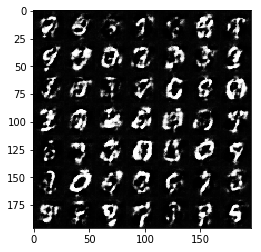

Epoch:1, Step:400, Discriminator Loss:0.4595116376876831, Generator Loss:2.6439032554626465
Epoch:1, Step:410, Discriminator Loss:0.50638347864151, Generator Loss:2.2936999797821045
Epoch:1, Step:420, Discriminator Loss:1.0531047582626343, Generator Loss:5.325992584228516
Epoch:1, Step:430, Discriminator Loss:0.4963173270225525, Generator Loss:2.384636878967285
Epoch:1, Step:440, Discriminator Loss:0.5040215849876404, Generator Loss:2.16328763961792
Epoch:1, Step:450, Discriminator Loss:0.4882667064666748, Generator Loss:2.2514889240264893
Epoch:1, Step:460, Discriminator Loss:0.584725558757782, Generator Loss:1.860177755355835
Epoch:1, Step:470, Discriminator Loss:0.5086690783500671, Generator Loss:2.483191728591919
Epoch:1, Step:480, Discriminator Loss:0.5459166765213013, Generator Loss:3.0480093955993652
Epoch:1, Step:490, Discriminator Loss:0.4475833475589752, Generator Loss:2.717374801635742


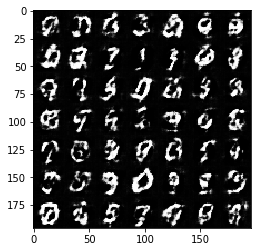

Epoch:1, Step:500, Discriminator Loss:0.7770692110061646, Generator Loss:1.421865463256836
Epoch:1, Step:510, Discriminator Loss:0.46905550360679626, Generator Loss:2.382662057876587
Epoch:1, Step:520, Discriminator Loss:0.513691246509552, Generator Loss:3.2502617835998535
Epoch:1, Step:530, Discriminator Loss:0.4561457931995392, Generator Loss:3.225929021835327
Epoch:1, Step:540, Discriminator Loss:0.4815276265144348, Generator Loss:2.3780758380889893
Epoch:1, Step:550, Discriminator Loss:0.4798125624656677, Generator Loss:2.7506661415100098
Epoch:1, Step:560, Discriminator Loss:0.4421922564506531, Generator Loss:2.713214874267578
Epoch:1, Step:570, Discriminator Loss:0.47888028621673584, Generator Loss:2.764852285385132
Epoch:1, Step:580, Discriminator Loss:0.6478235125541687, Generator Loss:1.929582953453064
Epoch:1, Step:590, Discriminator Loss:0.5430805683135986, Generator Loss:3.449152946472168


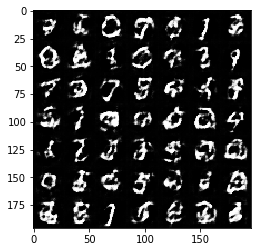

Epoch:1, Step:600, Discriminator Loss:0.48632460832595825, Generator Loss:2.4304492473602295
Epoch:2, Step:610, Discriminator Loss:0.5097432136535645, Generator Loss:2.7454183101654053
Epoch:2, Step:620, Discriminator Loss:0.4994773268699646, Generator Loss:3.0766139030456543
Epoch:2, Step:630, Discriminator Loss:0.6119475960731506, Generator Loss:3.9142680168151855
Epoch:2, Step:640, Discriminator Loss:0.4857794940471649, Generator Loss:2.8880882263183594
Epoch:2, Step:650, Discriminator Loss:0.4652353525161743, Generator Loss:3.131824493408203
Epoch:2, Step:660, Discriminator Loss:0.4844406545162201, Generator Loss:2.589378833770752
Epoch:2, Step:670, Discriminator Loss:0.48532634973526, Generator Loss:2.8195176124572754
Epoch:2, Step:680, Discriminator Loss:0.47254425287246704, Generator Loss:2.631718635559082
Epoch:2, Step:690, Discriminator Loss:1.0944616794586182, Generator Loss:4.069680690765381


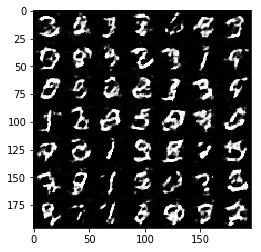

Epoch:2, Step:700, Discriminator Loss:0.6072204113006592, Generator Loss:1.7783046960830688
Epoch:2, Step:710, Discriminator Loss:0.6120584011077881, Generator Loss:1.6613147258758545
Epoch:2, Step:720, Discriminator Loss:1.4462608098983765, Generator Loss:5.00241756439209
Epoch:2, Step:730, Discriminator Loss:0.6596221923828125, Generator Loss:1.5935341119766235
Epoch:2, Step:740, Discriminator Loss:0.6393260955810547, Generator Loss:3.0859105587005615
Epoch:2, Step:750, Discriminator Loss:0.5581520795822144, Generator Loss:2.145840883255005
Epoch:2, Step:760, Discriminator Loss:0.586833119392395, Generator Loss:1.7312140464782715
Epoch:2, Step:770, Discriminator Loss:1.0762735605239868, Generator Loss:1.2127716541290283
Epoch:2, Step:780, Discriminator Loss:0.5235849618911743, Generator Loss:2.9697749614715576
Epoch:2, Step:790, Discriminator Loss:0.7229989171028137, Generator Loss:1.4134713411331177


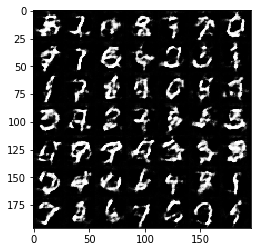

Epoch:2, Step:800, Discriminator Loss:0.5364810228347778, Generator Loss:2.095233917236328
Epoch:2, Step:810, Discriminator Loss:0.5533890724182129, Generator Loss:2.3736743927001953
Epoch:2, Step:820, Discriminator Loss:0.751695990562439, Generator Loss:1.3343003988265991
Epoch:2, Step:830, Discriminator Loss:0.8312023282051086, Generator Loss:1.1757750511169434
Epoch:2, Step:840, Discriminator Loss:0.5910441875457764, Generator Loss:1.8343982696533203
Epoch:2, Step:850, Discriminator Loss:0.6100683212280273, Generator Loss:1.8069307804107666
Epoch:2, Step:860, Discriminator Loss:0.5565019845962524, Generator Loss:2.156806468963623
Epoch:2, Step:870, Discriminator Loss:0.6193143129348755, Generator Loss:3.1321842670440674
Epoch:2, Step:880, Discriminator Loss:0.8964893817901611, Generator Loss:3.8655152320861816
Epoch:2, Step:890, Discriminator Loss:1.083014726638794, Generator Loss:0.9560021758079529


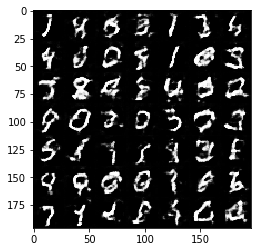

Epoch:2, Step:900, Discriminator Loss:0.682708740234375, Generator Loss:1.5476830005645752
Epoch:2, Step:910, Discriminator Loss:1.0907726287841797, Generator Loss:0.8410406708717346
Epoch:2, Step:920, Discriminator Loss:0.6365240812301636, Generator Loss:1.6597052812576294
Epoch:2, Step:930, Discriminator Loss:0.6411573886871338, Generator Loss:1.5860364437103271
Epoch:2, Step:940, Discriminator Loss:0.6064808368682861, Generator Loss:1.740585446357727
Epoch:2, Step:950, Discriminator Loss:0.6510568857192993, Generator Loss:1.5321546792984009
Epoch:2, Step:960, Discriminator Loss:0.7801496982574463, Generator Loss:1.317556619644165
Epoch:2, Step:970, Discriminator Loss:0.5615771412849426, Generator Loss:2.040628433227539
Epoch:2, Step:980, Discriminator Loss:0.6380258202552795, Generator Loss:1.7287486791610718
Epoch:2, Step:990, Discriminator Loss:0.9290755987167358, Generator Loss:1.0232694149017334


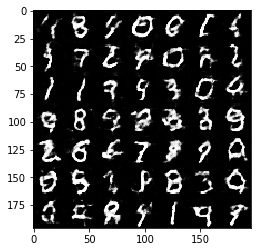

Epoch:2, Step:1000, Discriminator Loss:0.5954835414886475, Generator Loss:2.3506860733032227
Epoch:2, Step:1010, Discriminator Loss:1.1913909912109375, Generator Loss:4.018765449523926
Epoch:2, Step:1020, Discriminator Loss:0.7056795954704285, Generator Loss:2.967022657394409
Epoch:2, Step:1030, Discriminator Loss:0.6400182247161865, Generator Loss:1.7483575344085693
Epoch:2, Step:1040, Discriminator Loss:1.304347276687622, Generator Loss:0.6870673298835754
Epoch:2, Step:1050, Discriminator Loss:0.9223204255104065, Generator Loss:0.9936549067497253
Epoch:2, Step:1060, Discriminator Loss:0.729558527469635, Generator Loss:1.402406930923462
Epoch:2, Step:1070, Discriminator Loss:0.6893218755722046, Generator Loss:1.5250990390777588
Epoch:2, Step:1080, Discriminator Loss:1.1987900733947754, Generator Loss:3.756396770477295
Epoch:2, Step:1090, Discriminator Loss:0.6189490556716919, Generator Loss:2.228060245513916


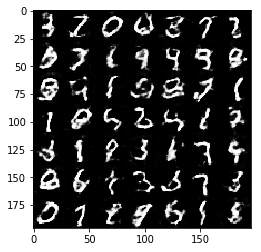

Epoch:2, Step:1100, Discriminator Loss:0.7932398319244385, Generator Loss:3.0362865924835205
Epoch:2, Step:1110, Discriminator Loss:0.6202605962753296, Generator Loss:1.7146040201187134
Epoch:2, Step:1120, Discriminator Loss:0.8646780848503113, Generator Loss:3.198343276977539
Epoch:2, Step:1130, Discriminator Loss:0.5508768558502197, Generator Loss:2.5642170906066895
Epoch:2, Step:1140, Discriminator Loss:0.732804000377655, Generator Loss:1.3137344121932983
Epoch:2, Step:1150, Discriminator Loss:0.6580063104629517, Generator Loss:1.6835618019104004
Epoch:2, Step:1160, Discriminator Loss:0.6133099794387817, Generator Loss:1.7601202726364136
Epoch:2, Step:1170, Discriminator Loss:0.5922651886940002, Generator Loss:2.5512638092041016
Epoch:2, Step:1180, Discriminator Loss:0.9934431910514832, Generator Loss:0.8775919079780579
Epoch:2, Step:1190, Discriminator Loss:1.4948630332946777, Generator Loss:4.749392032623291


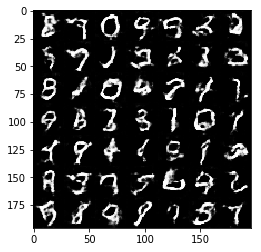

Epoch:2, Step:1200, Discriminator Loss:0.6524133682250977, Generator Loss:1.569039225578308


In [17]:
batch_size = 100
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch:1, Step:10, Discriminator Loss:0.8386054039001465, Generator Loss:1.5564301013946533
Epoch:1, Step:20, Discriminator Loss:0.6202642917633057, Generator Loss:1.835578441619873
Epoch:1, Step:30, Discriminator Loss:0.5271292924880981, Generator Loss:2.4167897701263428
Epoch:1, Step:40, Discriminator Loss:0.48677653074264526, Generator Loss:2.5413355827331543
Epoch:1, Step:50, Discriminator Loss:0.4421886205673218, Generator Loss:3.5118865966796875
Epoch:1, Step:60, Discriminator Loss:0.47140103578567505, Generator Loss:2.542078971862793
Epoch:1, Step:70, Discriminator Loss:0.6825674772262573, Generator Loss:1.7485417127609253
Epoch:1, Step:80, Discriminator Loss:0.7691797018051147, Generator Loss:4.517027854919434
Epoch:1, Step:90, Discriminator Loss:1.2519965171813965, Generator Loss:6.467533111572266


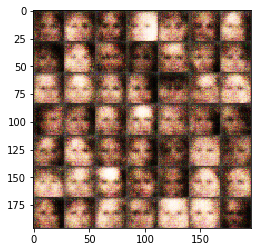

Epoch:1, Step:100, Discriminator Loss:0.8474482297897339, Generator Loss:1.3051977157592773
Epoch:1, Step:110, Discriminator Loss:0.8205705881118774, Generator Loss:1.4439115524291992
Epoch:1, Step:120, Discriminator Loss:0.7482624650001526, Generator Loss:1.4418046474456787
Epoch:1, Step:130, Discriminator Loss:1.5630357265472412, Generator Loss:0.557834267616272
Epoch:1, Step:140, Discriminator Loss:0.7552939653396606, Generator Loss:2.731921672821045
Epoch:1, Step:150, Discriminator Loss:0.6930515170097351, Generator Loss:1.8079321384429932
Epoch:1, Step:160, Discriminator Loss:0.6711092591285706, Generator Loss:2.0910942554473877
Epoch:1, Step:170, Discriminator Loss:1.040921926498413, Generator Loss:0.9277482628822327
Epoch:1, Step:180, Discriminator Loss:0.6505603790283203, Generator Loss:2.060634136199951
Epoch:1, Step:190, Discriminator Loss:0.6805439591407776, Generator Loss:3.4340076446533203


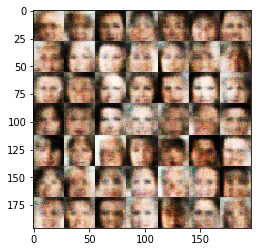

Epoch:1, Step:200, Discriminator Loss:0.6562318205833435, Generator Loss:1.8847243785858154
Epoch:1, Step:210, Discriminator Loss:0.7935265302658081, Generator Loss:1.8090077638626099
Epoch:1, Step:220, Discriminator Loss:1.0834177732467651, Generator Loss:1.3181545734405518
Epoch:1, Step:230, Discriminator Loss:1.0320842266082764, Generator Loss:0.9063783884048462
Epoch:1, Step:240, Discriminator Loss:1.17296302318573, Generator Loss:2.1980550289154053
Epoch:1, Step:250, Discriminator Loss:1.2172437906265259, Generator Loss:2.586014747619629
Epoch:1, Step:260, Discriminator Loss:1.0498796701431274, Generator Loss:2.4708962440490723
Epoch:1, Step:270, Discriminator Loss:1.0156505107879639, Generator Loss:1.027122139930725
Epoch:1, Step:280, Discriminator Loss:0.8823462128639221, Generator Loss:1.1911356449127197
Epoch:1, Step:290, Discriminator Loss:1.16074800491333, Generator Loss:0.7438726425170898


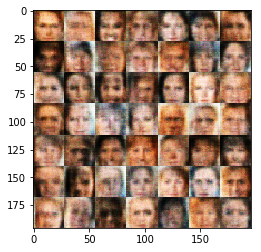

Epoch:1, Step:300, Discriminator Loss:0.8000774383544922, Generator Loss:2.1388192176818848
Epoch:1, Step:310, Discriminator Loss:0.8782517910003662, Generator Loss:1.2335337400436401
Epoch:1, Step:320, Discriminator Loss:0.9445256590843201, Generator Loss:1.2000631093978882
Epoch:1, Step:330, Discriminator Loss:1.0688579082489014, Generator Loss:2.129793405532837
Epoch:1, Step:340, Discriminator Loss:1.0950747728347778, Generator Loss:0.8144468665122986
Epoch:1, Step:350, Discriminator Loss:0.7713274955749512, Generator Loss:2.7402126789093018
Epoch:1, Step:360, Discriminator Loss:0.7190786600112915, Generator Loss:1.798095941543579
Epoch:1, Step:370, Discriminator Loss:2.03965163230896, Generator Loss:4.242650032043457
Epoch:1, Step:380, Discriminator Loss:0.7863731384277344, Generator Loss:1.3541760444641113
Epoch:1, Step:390, Discriminator Loss:0.82716965675354, Generator Loss:3.062558650970459


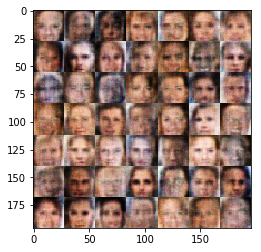

Epoch:1, Step:400, Discriminator Loss:1.3378243446350098, Generator Loss:0.5930806398391724
Epoch:1, Step:410, Discriminator Loss:0.6970874071121216, Generator Loss:1.5360422134399414
Epoch:1, Step:420, Discriminator Loss:0.6995882987976074, Generator Loss:1.4485112428665161
Epoch:1, Step:430, Discriminator Loss:0.8773380517959595, Generator Loss:1.6015808582305908
Epoch:1, Step:440, Discriminator Loss:0.7157642841339111, Generator Loss:1.5659624338150024
Epoch:1, Step:450, Discriminator Loss:1.1140823364257812, Generator Loss:2.507750988006592
Epoch:1, Step:460, Discriminator Loss:0.9484351873397827, Generator Loss:1.080130934715271
Epoch:1, Step:470, Discriminator Loss:1.346152424812317, Generator Loss:0.5748327970504761
Epoch:1, Step:480, Discriminator Loss:0.8283123970031738, Generator Loss:1.4959170818328857
Epoch:1, Step:490, Discriminator Loss:1.1003780364990234, Generator Loss:0.9833333492279053


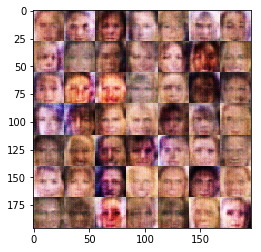

Epoch:1, Step:500, Discriminator Loss:1.0887038707733154, Generator Loss:1.2003495693206787
Epoch:1, Step:510, Discriminator Loss:0.7639552354812622, Generator Loss:1.9330804347991943
Epoch:1, Step:520, Discriminator Loss:1.0705578327178955, Generator Loss:2.0477285385131836
Epoch:1, Step:530, Discriminator Loss:1.415539026260376, Generator Loss:0.5341466665267944
Epoch:1, Step:540, Discriminator Loss:1.1393499374389648, Generator Loss:1.9411430358886719
Epoch:1, Step:550, Discriminator Loss:0.9559180736541748, Generator Loss:1.5747528076171875
Epoch:1, Step:560, Discriminator Loss:1.142403483390808, Generator Loss:0.8003190755844116
Epoch:1, Step:570, Discriminator Loss:1.284000039100647, Generator Loss:2.7792258262634277
Epoch:1, Step:580, Discriminator Loss:1.0827065706253052, Generator Loss:1.3447694778442383
Epoch:1, Step:590, Discriminator Loss:1.185250997543335, Generator Loss:0.7204234600067139


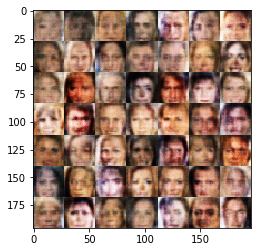

Epoch:1, Step:600, Discriminator Loss:1.0142807960510254, Generator Loss:0.9692953824996948
Epoch:1, Step:610, Discriminator Loss:1.1588598489761353, Generator Loss:1.7768950462341309
Epoch:1, Step:620, Discriminator Loss:1.1288223266601562, Generator Loss:0.7282397747039795
Epoch:1, Step:630, Discriminator Loss:1.2984055280685425, Generator Loss:1.9115116596221924
Epoch:1, Step:640, Discriminator Loss:1.401796579360962, Generator Loss:0.5911917686462402
Epoch:1, Step:650, Discriminator Loss:1.061732530593872, Generator Loss:1.0060956478118896
Epoch:1, Step:660, Discriminator Loss:1.4667789936065674, Generator Loss:2.6931557655334473
Epoch:1, Step:670, Discriminator Loss:0.9316621422767639, Generator Loss:1.1327056884765625
Epoch:1, Step:680, Discriminator Loss:1.828903317451477, Generator Loss:0.30811601877212524
Epoch:1, Step:690, Discriminator Loss:0.9781699180603027, Generator Loss:1.4752588272094727


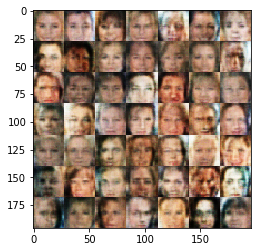

Epoch:1, Step:700, Discriminator Loss:1.0419487953186035, Generator Loss:1.2855448722839355
Epoch:1, Step:710, Discriminator Loss:1.3244731426239014, Generator Loss:2.2866077423095703
Epoch:1, Step:720, Discriminator Loss:1.0067031383514404, Generator Loss:1.126539707183838
Epoch:1, Step:730, Discriminator Loss:0.984486997127533, Generator Loss:1.0145708322525024
Epoch:1, Step:740, Discriminator Loss:1.0244697332382202, Generator Loss:0.863466203212738
Epoch:1, Step:750, Discriminator Loss:1.573502540588379, Generator Loss:2.61576509475708
Epoch:1, Step:760, Discriminator Loss:1.1239686012268066, Generator Loss:0.9139171838760376
Epoch:1, Step:770, Discriminator Loss:1.3743610382080078, Generator Loss:0.5323401689529419
Epoch:1, Step:780, Discriminator Loss:1.1407428979873657, Generator Loss:1.048192024230957
Epoch:1, Step:790, Discriminator Loss:0.9318917989730835, Generator Loss:1.1631574630737305


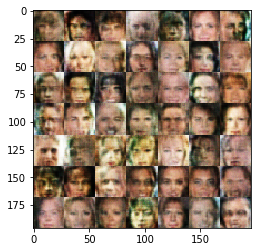

Epoch:1, Step:800, Discriminator Loss:0.9993310570716858, Generator Loss:1.0110223293304443
Epoch:1, Step:810, Discriminator Loss:0.9708040356636047, Generator Loss:1.353910207748413
Epoch:1, Step:820, Discriminator Loss:0.8610244393348694, Generator Loss:1.604498267173767
Epoch:1, Step:830, Discriminator Loss:0.9120587110519409, Generator Loss:1.29854416847229
Epoch:1, Step:840, Discriminator Loss:1.0288429260253906, Generator Loss:0.8839932680130005
Epoch:1, Step:850, Discriminator Loss:1.0565693378448486, Generator Loss:1.4438083171844482
Epoch:1, Step:860, Discriminator Loss:1.2928776741027832, Generator Loss:2.6028459072113037
Epoch:1, Step:870, Discriminator Loss:1.1965200901031494, Generator Loss:0.7385269403457642
Epoch:1, Step:880, Discriminator Loss:0.9738805890083313, Generator Loss:1.0231213569641113
Epoch:1, Step:890, Discriminator Loss:1.3748807907104492, Generator Loss:0.5229678153991699


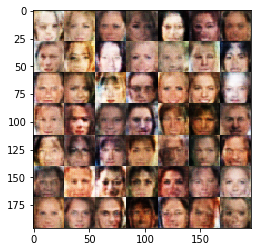

Epoch:1, Step:900, Discriminator Loss:0.9412885308265686, Generator Loss:1.8275853395462036
Epoch:1, Step:910, Discriminator Loss:1.2849106788635254, Generator Loss:0.5685063004493713
Epoch:1, Step:920, Discriminator Loss:1.2496728897094727, Generator Loss:0.6306168437004089
Epoch:1, Step:930, Discriminator Loss:0.8917980790138245, Generator Loss:1.7823894023895264
Epoch:1, Step:940, Discriminator Loss:1.0479639768600464, Generator Loss:2.095123291015625
Epoch:1, Step:950, Discriminator Loss:0.8422839641571045, Generator Loss:1.2117304801940918
Epoch:1, Step:960, Discriminator Loss:1.7478752136230469, Generator Loss:3.261228084564209
Epoch:1, Step:970, Discriminator Loss:0.9131669402122498, Generator Loss:1.0859428644180298
Epoch:1, Step:980, Discriminator Loss:1.0232609510421753, Generator Loss:0.8505096435546875
Epoch:1, Step:990, Discriminator Loss:1.4680176973342896, Generator Loss:2.775667667388916


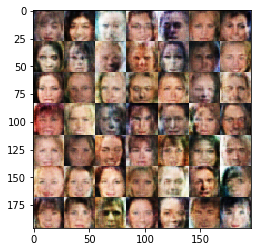

Epoch:1, Step:1000, Discriminator Loss:0.9307904243469238, Generator Loss:1.9663714170455933
Epoch:1, Step:1010, Discriminator Loss:0.8388745784759521, Generator Loss:1.856248378753662
Epoch:1, Step:1020, Discriminator Loss:0.990679144859314, Generator Loss:0.8811938762664795
Epoch:1, Step:1030, Discriminator Loss:0.8367455005645752, Generator Loss:1.4126478433609009
Epoch:1, Step:1040, Discriminator Loss:1.216304063796997, Generator Loss:2.3544368743896484
Epoch:1, Step:1050, Discriminator Loss:0.8113166093826294, Generator Loss:1.3332087993621826
Epoch:1, Step:1060, Discriminator Loss:0.9577215909957886, Generator Loss:2.581951379776001
Epoch:1, Step:1070, Discriminator Loss:0.9906983375549316, Generator Loss:1.0582449436187744
Epoch:1, Step:1080, Discriminator Loss:1.033663034439087, Generator Loss:0.806524932384491
Epoch:1, Step:1090, Discriminator Loss:0.9068825244903564, Generator Loss:0.974065899848938


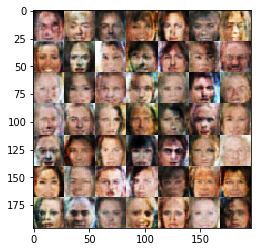

Epoch:1, Step:1100, Discriminator Loss:0.9919880032539368, Generator Loss:0.8843218088150024
Epoch:1, Step:1110, Discriminator Loss:1.0210682153701782, Generator Loss:2.7064661979675293
Epoch:1, Step:1120, Discriminator Loss:0.9341461062431335, Generator Loss:1.4475817680358887
Epoch:1, Step:1130, Discriminator Loss:0.8396928310394287, Generator Loss:1.1989541053771973
Epoch:1, Step:1140, Discriminator Loss:0.6892091035842896, Generator Loss:1.986337661743164
Epoch:1, Step:1150, Discriminator Loss:1.0832239389419556, Generator Loss:2.0092060565948486
Epoch:1, Step:1160, Discriminator Loss:0.9153375625610352, Generator Loss:1.042557954788208
Epoch:1, Step:1170, Discriminator Loss:0.7205586433410645, Generator Loss:1.422493815422058
Epoch:1, Step:1180, Discriminator Loss:0.6826788187026978, Generator Loss:1.8212227821350098
Epoch:1, Step:1190, Discriminator Loss:0.9540501832962036, Generator Loss:0.9061588048934937


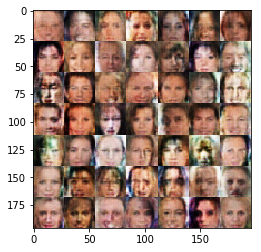

Epoch:1, Step:1200, Discriminator Loss:0.914169192314148, Generator Loss:1.0331768989562988
Epoch:1, Step:1210, Discriminator Loss:0.7931867837905884, Generator Loss:1.4339354038238525
Epoch:1, Step:1220, Discriminator Loss:1.088426113128662, Generator Loss:0.7455147504806519
Epoch:1, Step:1230, Discriminator Loss:0.9198170304298401, Generator Loss:2.2788748741149902
Epoch:1, Step:1240, Discriminator Loss:0.7897568345069885, Generator Loss:1.2226777076721191
Epoch:1, Step:1250, Discriminator Loss:1.0622138977050781, Generator Loss:0.8060511350631714
Epoch:1, Step:1260, Discriminator Loss:0.8055945038795471, Generator Loss:1.2018970251083374
Epoch:1, Step:1270, Discriminator Loss:1.0538681745529175, Generator Loss:0.8019793033599854
Epoch:1, Step:1280, Discriminator Loss:0.7892313003540039, Generator Loss:2.5245699882507324
Epoch:1, Step:1290, Discriminator Loss:0.6833692789077759, Generator Loss:1.6897761821746826


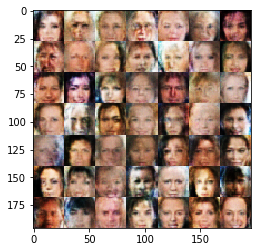

Epoch:1, Step:1300, Discriminator Loss:0.7307129502296448, Generator Loss:1.2694520950317383
Epoch:1, Step:1310, Discriminator Loss:2.9195432662963867, Generator Loss:5.222700595855713
Epoch:1, Step:1320, Discriminator Loss:0.8656092882156372, Generator Loss:1.7172682285308838
Epoch:1, Step:1330, Discriminator Loss:0.77176833152771, Generator Loss:1.635826826095581
Epoch:1, Step:1340, Discriminator Loss:0.6351686716079712, Generator Loss:2.341775894165039
Epoch:1, Step:1350, Discriminator Loss:0.5645266771316528, Generator Loss:2.004519462585449
Epoch:1, Step:1360, Discriminator Loss:1.4305797815322876, Generator Loss:3.2385058403015137
Epoch:1, Step:1370, Discriminator Loss:0.8324074149131775, Generator Loss:1.106313943862915
Epoch:1, Step:1380, Discriminator Loss:0.6625674962997437, Generator Loss:2.449354648590088
Epoch:1, Step:1390, Discriminator Loss:0.681348443031311, Generator Loss:1.902565836906433


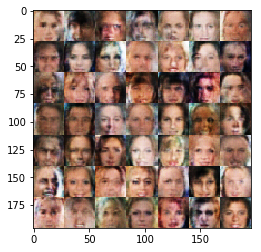

Epoch:1, Step:1400, Discriminator Loss:0.9242152571678162, Generator Loss:2.4953222274780273
Epoch:1, Step:1410, Discriminator Loss:0.7989968061447144, Generator Loss:1.176224946975708
Epoch:1, Step:1420, Discriminator Loss:0.7834466695785522, Generator Loss:1.612650752067566
Epoch:1, Step:1430, Discriminator Loss:0.6352957487106323, Generator Loss:2.689478874206543
Epoch:1, Step:1440, Discriminator Loss:0.546356737613678, Generator Loss:2.358018159866333
Epoch:1, Step:1450, Discriminator Loss:0.4935140609741211, Generator Loss:2.42682147026062
Epoch:1, Step:1460, Discriminator Loss:0.5164971351623535, Generator Loss:2.681194305419922
Epoch:1, Step:1470, Discriminator Loss:0.5398173332214355, Generator Loss:1.9502604007720947
Epoch:1, Step:1480, Discriminator Loss:0.8972763419151306, Generator Loss:1.3823509216308594
Epoch:1, Step:1490, Discriminator Loss:0.7881281971931458, Generator Loss:1.4694976806640625


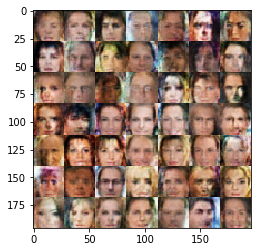

Epoch:1, Step:1500, Discriminator Loss:0.7991535663604736, Generator Loss:1.2371490001678467
Epoch:1, Step:1510, Discriminator Loss:0.8631190061569214, Generator Loss:1.0331952571868896
Epoch:1, Step:1520, Discriminator Loss:0.7937268614768982, Generator Loss:1.5625948905944824
Epoch:1, Step:1530, Discriminator Loss:0.7494747638702393, Generator Loss:1.4199581146240234
Epoch:1, Step:1540, Discriminator Loss:0.6163049936294556, Generator Loss:1.814435601234436
Epoch:1, Step:1550, Discriminator Loss:0.5382517576217651, Generator Loss:3.378326416015625
Epoch:1, Step:1560, Discriminator Loss:0.6007348299026489, Generator Loss:3.1529629230499268
Epoch:1, Step:1570, Discriminator Loss:0.5263041257858276, Generator Loss:2.460069179534912
Epoch:1, Step:1580, Discriminator Loss:1.0869321823120117, Generator Loss:3.2721946239471436


In [19]:
batch_size = 128
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.